<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-Torch-Model" data-toc-modified-id="Create-Torch-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create Torch Model</a></span></li><li><span><a href="#Neural-Nets-in-Numpy" data-toc-modified-id="Neural-Nets-in-Numpy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Neural Nets in Numpy</a></span><ul class="toc-item"><li><span><a href="#Copy-weights-from-torch-model" data-toc-modified-id="Copy-weights-from-torch-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Copy weights from torch model</a></span></li><li><span><a href="#Forward-pass-in-numpy" data-toc-modified-id="Forward-pass-in-numpy-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Forward pass in numpy</a></span></li><li><span><a href="#Uncertainity" data-toc-modified-id="Uncertainity-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Uncertainity</a></span></li></ul></li></ul></div>

In [32]:
import torch
import os
from tqdm import trange
import matplotlib.pyplot as plt
import requests, gzip, os, hashlib
import numpy as np

#fetch data
path = 'tmp'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# Create Torch Model

In [95]:
BATCH_SIZE = 256

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 784)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 784)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [112]:
from torch import nn

class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10, bias=False)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x


acc 0.8175310284533399
loss 1.387548816204071

acc 0.9033559164963663
loss 0.3634393599932082

acc 0.9260762534104288
loss 0.2719636535621248

acc 0.9351908366661519
loss 0.2289776833204087

acc 0.9440714519005269
loss 0.19903773823170923

acc 0.9492136638145894
loss 0.17999777692602947

acc 0.9546101887244731
loss 0.1619672687666025

acc 0.9574839272536337
loss 0.15006567396631

acc 0.9612986245192587
loss 0.13913179724477232

acc 0.9636942544020712
loss 0.12996067041240167



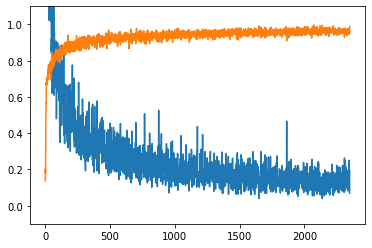

In [113]:
EPOCHS = 10

model = BobNet()
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
cross_entropy = nn.CrossEntropyLoss()

accuracies, losses = [], []

for i in range(EPOCHS):
    for image, label in train_dl:
        optim.zero_grad()
        out = model(image)
        cat = torch.argmax(out, dim=1)
        acc = (cat == label).float().mean()
        
        loss = cross_entropy(out, label)
        loss.backward()
        optim.step()
        
        accuracies.append(acc.item())
        losses.append(loss.item())
    print('acc', np.mean(accuracies[-BATCH_SIZE:]))
    print('loss', np.mean(losses[-BATCH_SIZE:]))
    print()
    
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [114]:
y_test_pred = torch.argmax(model(X_test_tensor), dim=1)
(y_test_pred == y_test_tensor).numpy().mean()

0.9498

# Neural Nets in Numpy

## Copy weights from torch model

In [130]:
l1 = np.zeros([128, 784], dtype=np.float32)
l2 = np.zeros([10, 128], dtype=np.float32)

# Copy Weights
l1[:] = model.l1.weight.detach().numpy()
l2[:] = model.l2.weight.detach().numpy()

## Forward pass in numpy

In [226]:
def forward(x):
    x = x.dot(l1.T)
    x = np.maximum(0, x)
    x = x.dot(l2.T)
    return x

def numpy_eval(x, y):
    pred = forward(x)
    pred_cat = np.argmax(pred, axis=1)
    return (pred_cat == y).mean()

acc 0.9498


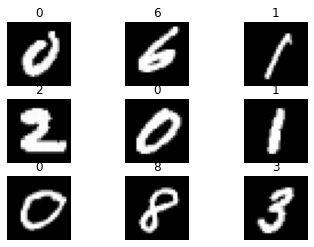

In [227]:
fig = plt.figure()
for i in range(3 * 3):
    rand = np.random.randint(len(X_train))
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(X_train[rand], cmap='gray')
    plt.title(np.argmax(forward(X_train.reshape(-1, 784)[rand])))
    plt.axis(False)
    
print('acc', numpy_eval(X_test, y_test))

## Uncertainity

In [234]:
y_pred = forward(X_test.reshape(-1, 784))
ret = - np.max(y_pred, axis=1) + np.log(np.exp(y_pred).sum(axis=1))
print(ret)

[1.0080338e-03 4.6634674e-02 1.6498566e-04 ... 6.1035156e-05 5.0163269e-04
 5.5313110e-05]


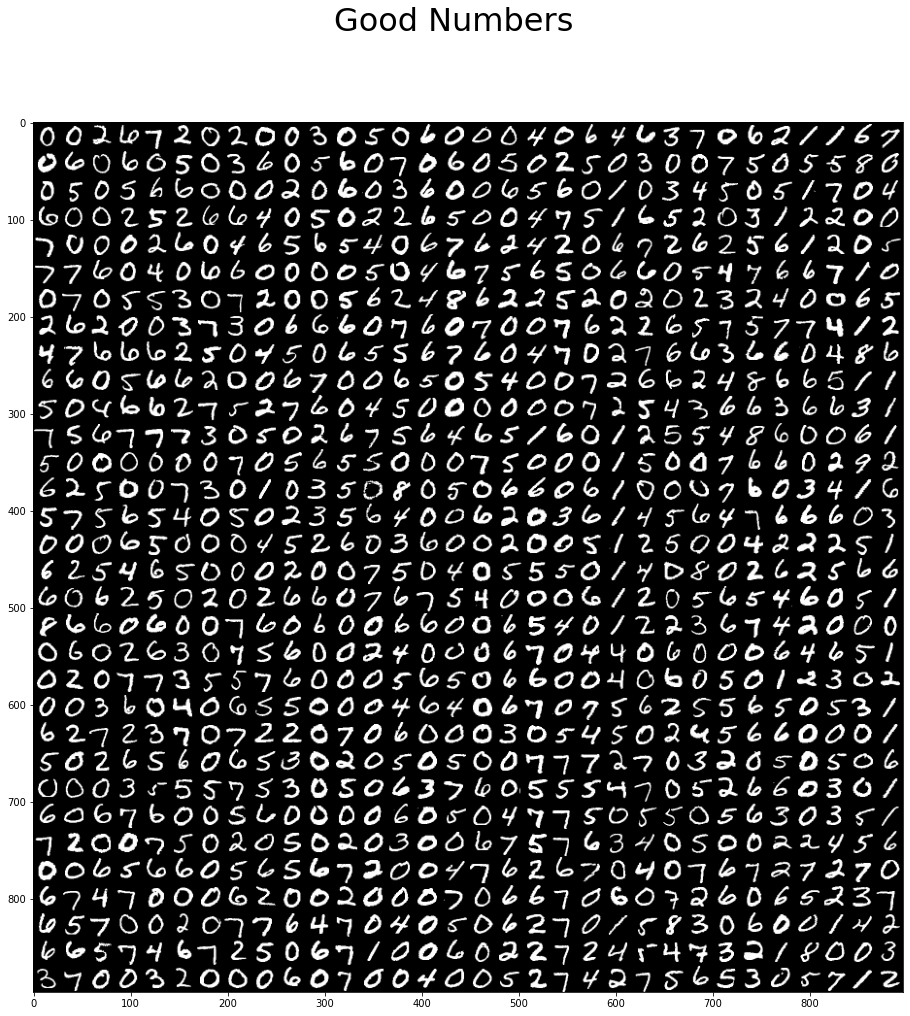

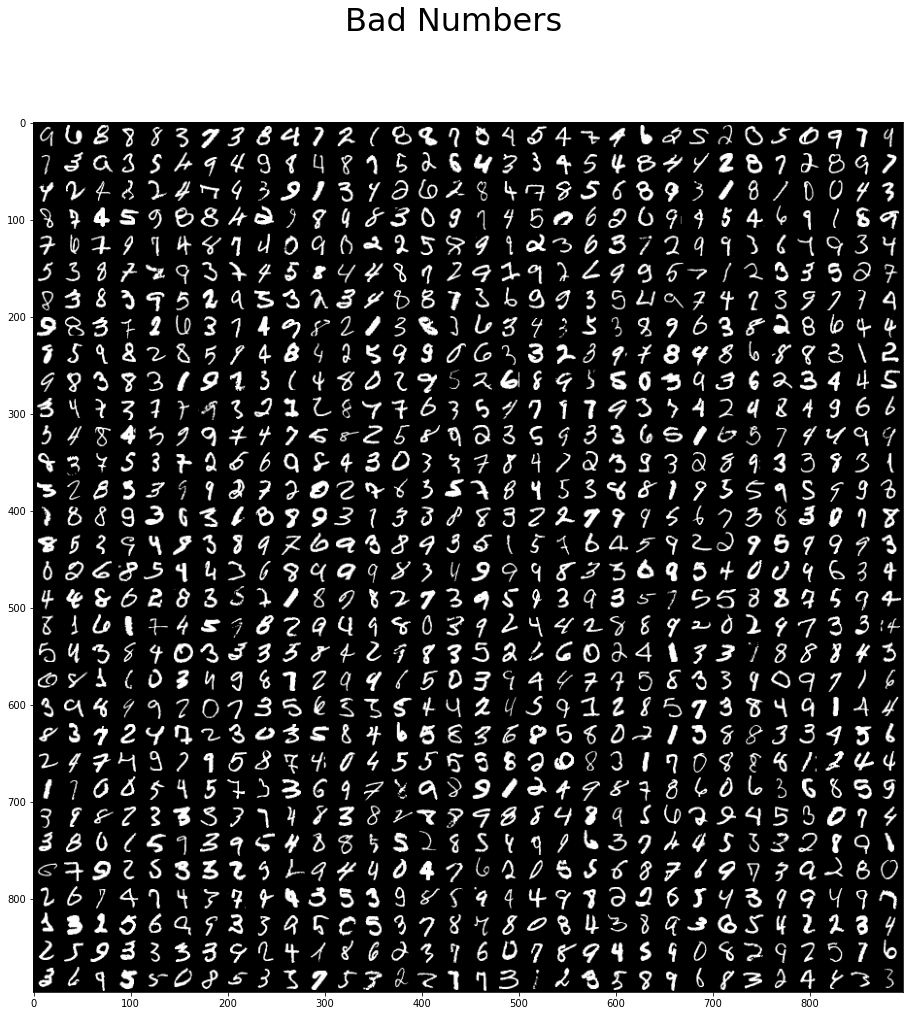

In [235]:
ROW = 32

bad_image = sorted(list(zip(ret, range(len(y_pred)))), reverse=True)[:ROW**2]
bad_image = X_test[[x[1] for x in bad_image]]
gud_image = sorted(list(zip(ret, range(len(y_pred)))), reverse=False)[:ROW**2]
gud_image = X_test[[x[1] for x in gud_image]]

fig = plt.figure(figsize=(16, 16)); fig.suptitle('Good Numbers', fontsize=32)
plt.imshow(np.concatenate(gud_image.reshape(ROW, ROW * 28, 28), axis=1), 'gray')
fig = plt.figure(figsize=(16, 16)); fig.suptitle('Bad Numbers', fontsize=32)
plt.imshow(np.concatenate(bad_image.reshape(ROW, ROW * 28, 28), axis=1), 'gray')